In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in Metar Data downloaded in from IEM.
df = pd.read_csv("IEM_METAR.csv")

In [3]:
# show the first 5 rows of the data, this shows why we need process the data.
df.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,CYOD,2024-06-01 00:00,48.2,44.6,87.28,310.0,20.0,0.0,29.73,1008.2,...,-SHRA,M,M,M,M,M,M,40.66,CYOD 010000Z 31020G27KT 6SM -SHRA OVC030 09/07...,M
1,CYOD,2024-06-01 00:06,46.4,42.8,87.19,290.0,16.0,0.0,29.72,1008.1,...,-SHRA,M,M,M,M,M,M,39.19,CYOD 010006Z 29016G33KT 3SM -SHRA OVC030 08/06...,M
2,CYOD,2024-06-01 00:22,44.6,41.0,87.09,260.0,14.0,0.0,29.71,1007.7,...,-SHRA,M,M,M,M,M,M,37.40,CYOD 010022Z 26014KT 15SM -SHRA BKN035 07/05 A...,M
3,CYOD,2024-06-01 00:29,46.4,42.8,87.19,250.0,13.0,0.0,29.71,1007.7,...,M,M,M,M,M,M,M,40.02,CYOD 010029Z 25013KT 15SM SCT035 BKN075 08/06 ...,M
4,CYOD,2024-06-01 01:00,46.4,44.6,93.40,230.0,8.0,0.0,29.71,1007.7,...,M,M,M,M,M,M,M,41.85,CYOD 010100Z 23008KT 15SM SCT045 OVC090 08/07 ...,M


In [4]:
# Define the function to convert temperatures to Celsius and drop unnecessary columns
def process_weather_data(df):
    # Convert temperature columns from Fahrenheit to Celsius
    df['tmpc'] = (df['tmpf'] - 32) * 5 / 9
    df['dwpc'] = (df['dwpf'] - 32) * 5 / 9

    # Select columns to keep (assuming essential weather data)
    columns_to_keep = ['station', 'valid', 'tmpc', 'dwpc', 'relh', 'drct', 'sknt', 'p01i', 'mslp', 'vsby', 'wxcodes', 'skyc1', 'skyl1', 'skyc2', 'skyl2']
    df_processed = df[columns_to_keep].copy()

    # Return the processed dataframe
    return df_processed

# Apply the function to the dataframe
processed_df = process_weather_data(df)

In [5]:
processed_df.head()

,station,valid,tmpc,dwpc,relh,drct,sknt,p01i,mslp,vsby,wxcodes,skyc1,skyl1,skyc2,skyl2
0,CYOD,2024-06-01 00:00,9.0,7.0,87.28,310.0,20.0,0.0,1008.2,6.0,-SHRA,OVC,3000.00,M,M
1,CYOD,2024-06-01 00:06,8.0,6.0,87.19,290.0,16.0,0.0,1008.1,3.0,-SHRA,OVC,3000.00,M,M
2,CYOD,2024-06-01 00:22,7.0,5.0,87.09,260.0,14.0,0.0,1007.7,15.0,-SHRA,BKN,3500.00,M,M
3,CYOD,2024-06-01 00:29,8.0,6.0,87.19,250.0,13.0,0.0,1007.7,15.0,M,SCT,3500.00,BKN,7500.00
4,CYOD,2024-06-01 01:00,8.0,7.0,93.40,230.0,8.0,0.0,1007.7,15.0,M,SCT,4500.00,OVC,9000.00


In [6]:
def calculate_tsra_duration(df):
    # Convert 'valid' to datetime
    df['valid'] = pd.to_datetime(df['valid'])

    # Sort by time to handle consecutive observations correctly
    df.sort_values(by='valid', inplace=True)

    # Filter for rows containing "TSRA" in any form within 'wxcodes'
    tsra_df = df[df['wxcodes'].str.contains(r'\b[-+]?TSRA\b', regex=True, na=False)].copy()

    # Ensure 'valid' is datetime to calculate time differences
    tsra_df['valid'] = pd.to_datetime(tsra_df['valid'])

    # Sort by time to handle consecutive observations correctly
    tsra_df.sort_values(by='valid', inplace=True)

    # Initialize variables for tracking durations
    total_duration = pd.Timedelta(0)
    current_start = None

    # Loop through each row to calculate contiguous "TSRA" periods
    for i in range(len(tsra_df) - 1):
        # Get current and next observation times
        current_time = tsra_df.iloc[i]['valid']
        next_time = tsra_df.iloc[i + 1]['valid']

        # Check if this is the start of a TSRA period
        if current_start is None:
            current_start = current_time

        # Calculate gap to determine if the TSRA period continues
        gap = next_time - current_time
        if gap > pd.Timedelta(minutes=20):  # Assumed threshold for consecutive observation
            # End current period and add its duration
            period_duration = current_time - current_start
            total_duration += period_duration
            current_start = None  # Reset for the next period

    # Account for any ongoing TSRA at the end of the list
    if current_start is not None:
        final_period_duration = tsra_df.iloc[-1]['valid'] - current_start
        total_duration += final_period_duration

    # Convert total duration to hours
    total_hours = total_duration.total_seconds() / 3600
    return total_hours

# Apply the function to the processed dataframe
tsra_hours = calculate_tsra_duration(processed_df)
print(f"Total Observing hours with TSRA contained in the WxCode is: {tsra_hours:.3} hrs")

Total Observing hours with TSRA contained in the WxCode is: 1.58 hrs


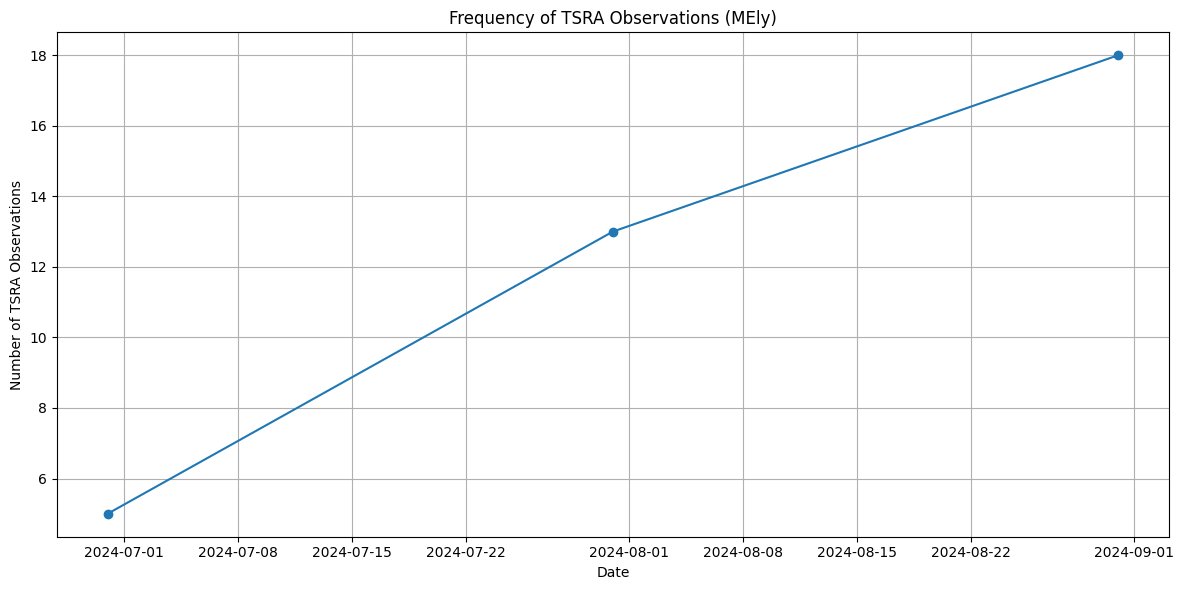

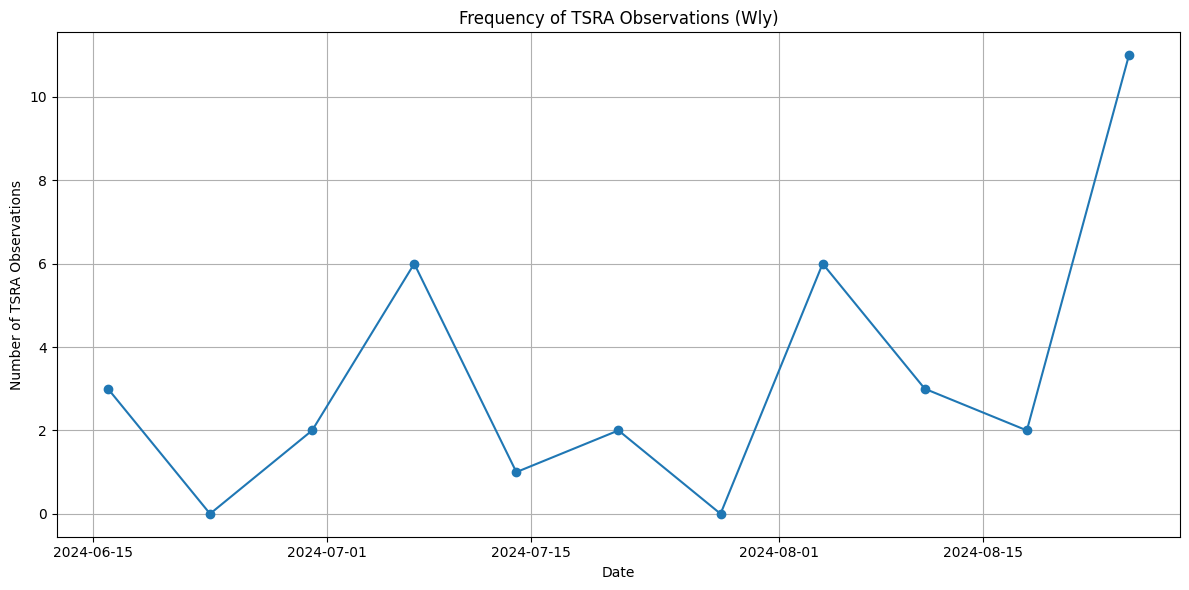

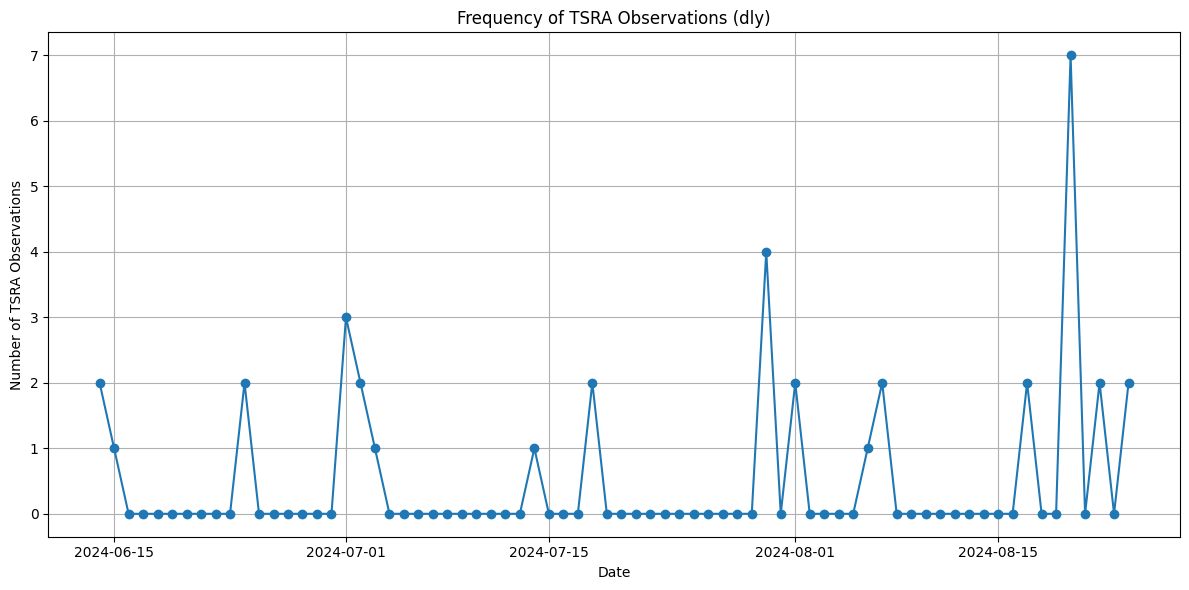

In [7]:
def analyze_tsra_trend(df, frequency='D'):
    # Filter for "TSRA" occurrences using a regex
    tsra_df = df[df['wxcodes'].str.contains(r'\b[-+]?TSRA\b', regex=True, na=False)].copy()

    # Convert 'valid' to datetime to enable resampling
    tsra_df['valid'] = pd.to_datetime(tsra_df['valid'])

    # Set 'valid' as the index to facilitate resampling
    tsra_df.set_index('valid', inplace=True)

    # Resample data to the chosen frequency ('D' for daily, 'M' for monthly)
    tsra_counts = tsra_df['wxcodes'].resample(frequency).count()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(tsra_counts.index, tsra_counts, marker='o', linestyle='-')
    plt.title(f"Frequency of TSRA Observations ({frequency}ly)")
    plt.xlabel("Date")
    plt.ylabel("Number of TSRA Observations")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return tsra_counts

# Call the function with daily frequency ('ME') to plot the daily trend of TSRA occurrences
tsra_trend_daily = analyze_tsra_trend(processed_df, frequency='ME')

# Call the function with daily frequency ('W') to plot the daily trend of TSRA occurrences
tsra_trend_daily = analyze_tsra_trend(processed_df, frequency='W')

# Call the function with daily frequency ('d') to plot the daily trend of TSRA occurrences
tsra_trend_daily = analyze_tsra_trend(processed_df, frequency='d')

# TAF PARSING

In [8]:
def process_taf_file(filepath):
    tafs = []
    with open(filepath, 'r') as file:
        lines = file.readlines()

        current_taf = []
        reading_taf = False

        for line in lines:
            # Skip the invalid text block at the beginning marked by ###
            if line.strip().startswith("#"):
                continue

            # Start reading the TAF when we encounter a line with a date (e.g., "202406010240")
            if re.match(r'^\d{12}', line):
                if current_taf:  # Save the previous TAF if exists
                    tafs.append(" ".join(current_taf))
                    current_taf = []
                reading_taf = True

            if reading_taf:
                # Append the line to the current TAF
                current_taf.append(line.strip())

                # If the line ends with "=", it marks the end of a TAF
                if line.strip().endswith("="):
                    tafs.append(" ".join(current_taf))
                    current_taf = []
                    reading_taf = False

    return tafs

In [9]:
# Example usage
taf_file_path = 'CYOD_TAF_June.txt'
tafs = process_taf_file(taf_file_path)

# Display the processed TAFs (for demonstration purposes)
for taf in tafs:
    print(taf)
    print("\n" + "="*50 + "\n")

202406010240 TAF CYOD 010240Z 0103/0124 23010KT P6SM FEW030 SCT060 BKN120 FM010900 30010KT P6SM FEW030 TEMPO 0109/0116 BKN030 BECMG 0114/0116 30015G25KT FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT RMK NXT FCST BY 010600Z=


202406010540 TAF CYOD 010540Z 0106/0206 23010KT P6SM FEW090 BKN110 FM010900 30010KT P6SM FEW030 TEMPO 0109/0116 BKN030 BECMG 0114/0116 30015G25KT FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT FM020300 VRB03KT P6SM SKC RMK NXT FCST BY 011200Z=


202406011140 TAF CYOD 011140Z 0112/0212 25010KT P6SM FEW100 BECMG 0114/0116 30015G25KT FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT FM020300 VRB03KT P6SM SKC RMK NXT FCST BY 011500Z=


202406011440 TAF CYOD 011440Z 0115/0212 28012KT P6SM FEW060 BECMG 0115/0116 30015G25KT FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT FM020300 VRB03KT P6SM SKC RMK NXT FCST BY 011800Z=


202406011740 TAF CYOD 011740Z 0118/0218 30015G25KT P6SM FEW060 BECMG 0122/0124 34010KT FM020300 VRB03KT P6SM SKC FM02

# Testing Hand doing stuff from single TAFs

In [10]:
taf_header = re.search(r'(\d{12} TAF( AMD)? ([A-Z]{4}) (\d{2})(\d{4})Z (\d{2})(\d{2})/(\d{2})(\d{2}))', tafs[0])

In [11]:
print(taf_header)

<re.Match object; span=(0, 39), match='202406010240 TAF CYOD 010240Z 0103/0124'>


In [12]:
# Parse the issue date
issue_date = taf_header.group(1)[:12]
issue_datetime = datetime.strptime(issue_date, "%Y%m%d%H%M")

In [13]:
# Parse the valid period day and hour components
valid_start_day = int(taf_header.group(6))
valid_start_hour = int(taf_header.group(7))
valid_end_day = int(taf_header.group(8))
valid_end_hour = int(taf_header.group(9))

In [14]:
# Construct the start and end times for the valid period
start_time = issue_datetime.replace(day=valid_start_day, hour=valid_start_hour, minute=0)
end_time = (issue_datetime.replace(day=valid_end_day, hour=0, minute=0) + timedelta(days=1) if valid_end_hour == 24
            else issue_datetime.replace(day=valid_end_day, hour=valid_end_hour, minute=0))

current_hour = start_time  # Initialize the current time pointer

In [15]:
# Parse the initial conditions after the header
taf_body_start = taf_header.end() + 1

In [16]:
taf = tafs[0]

In [17]:
taf[taf_body_start:]

'23010KT P6SM FEW030 SCT060 BKN120 FM010900 30010KT P6SM FEW030 TEMPO 0109/0116 BKN030 BECMG 0114/0116 30015G25KT FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT RMK NXT FCST BY 010600Z='

In [18]:
taf_string = taf[taf_body_start:]

# Split based on the pattern 'FM' followed by day and hour digits
segments = re.split(r'(?=FM\d{6}|RMK)', taf_string)

# Remove trailing '=' symbol if present in the last segment
segments = [seg.rstrip('=') for seg in segments]

# Print the parsed segments
for i, segment in enumerate(segments):
    print(f"Segment {i+1}: {segment}")

Segment 1: 23010KT P6SM FEW030 SCT060 BKN120 
Segment 2: FM010900 30010KT P6SM FEW030 TEMPO 0109/0116 BKN030 BECMG 0114/0116 30015G25KT 
Segment 3: FM011800 30015G25KT P6SM SCT050 BECMG 0122/0124 34010KT 
Segment 4: RMK NXT FCST BY 010600Z


In [39]:
def parse_taf_segment(segment):
    # Remove the RMK section and anything after it
    segment = re.split(r'RMK', segment)[0]

    # Define a pattern to match FM periods, TEMPO, BECMG, and PROB sections
    pattern = r'(?=FM\d{6}|TEMPO|BECMG|PROB\d{2})'

    # Split the segment and filter out any empty strings
    parts = [part for part in re.split(pattern, segment) if part.strip()]

    # Dictionary to store each part by type
    taf_parts = {"FM": [], "TEMPO": [], "BECMG": [], "PROB": []}

    # Define the keywords for categorization and set up the dictionary
    keyword_map = {"FM": "FM", "TEMPO": "TEMPO", "BECMG": "BECMG", "PROB": "PROB"}

    # Iterate over each part and categorize it based on its starting keyword
    for part in parts:
        # Strip all non-printable characters and extra whitespace
        part = re.sub(r'[^\S\n]+|\n+', ' ', part).strip()

        # Find the matching keyword from the start of the part
        keyword = next((key for key in keyword_map if part.startswith(key)), None)

        if keyword:
            taf_parts[keyword].append(part)
        else:
            # If it doesn't match any keyword, add it to the last FM entry
            if taf_parts["FM"]:
                taf_parts["FM"][-1] += " " + part
            else:
                taf_parts["FM"].append(part)

    return taf_parts

# Example usage with a segment
# taf_string = taf[taf_body_start:]
taf_string = """
29012KT 5SM -RA BR BKN009 OVC015
                      TEMPO 0515/0517 P6SM -RA SCT009 OVC015
                      BECMG 0515/0517 30015G25KT FM051700 30015G25KT
                       5SM -RA BR BKN012 OVC025
                      TEMPO 0517/0520 P6SM -RA SCT012 BKN025 FM052000
                       30015G25KT P6SM SCT015 BKN030
                      TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030
                       BECMG 0603/0604 32008KT FM060700 30005KT
                       6SM BR SCT004
                      PROB30 0607/0611 1SM BR OVC004 RMK NXT FCST
                       BY 051800Z=
"""
segments = re.split(r'(?=FM\d{6})', taf_string)
segments = [seg.rstrip('=') for seg in segments if seg.strip()]  # Filter out any empty strings

# Parse each segment
for i, segment in enumerate(segments):
    parsed_segment = parse_taf_segment(segment)
    print(f"Parsed Segment {i+1}: {parsed_segment}")


Parsed Segment 1: {'FM': ['29012KT 5SM -RA BR BKN009 OVC015'], 'TEMPO': ['TEMPO 0515/0517 P6SM -RA SCT009 OVC015'], 'BECMG': ['BECMG 0515/0517 30015G25KT'], 'PROB': []}
Parsed Segment 2: {'FM': ['FM051700 30015G25KT  5SM -RA BR BKN012 OVC025'], 'TEMPO': ['TEMPO 0517/0520 P6SM -RA SCT012 BKN025'], 'BECMG': [], 'PROB': []}
Parsed Segment 3: {'FM': ['FM052000  30015G25KT P6SM SCT015 BKN030'], 'TEMPO': ['TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030'], 'BECMG': ['BECMG 0603/0604 32008KT'], 'PROB': []}
Parsed Segment 4: {'FM': ['FM060700 30005KT  6SM BR SCT004'], 'TEMPO': [], 'BECMG': [], 'PROB': ['PROB30 0607/0611 1SM BR OVC004']}


In [45]:
# Initialize an empty dictionary to store parsed segments
all_parsed_segments = {}

# Parse each segment and store in dictionary
for i, segment in enumerate(segments, start=1):
    parsed_segment = parse_taf_segment(segment)
    # Use the segment number as the key
    all_parsed_segments[f"Segment {i}"] = parsed_segment

# Now `all_parsed_segments` contains all parsed segments by segment number
print(all_parsed_segments)

{'Segment 1': {'FM': ['29012KT 5SM -RA BR BKN009 OVC015'], 'TEMPO': ['TEMPO 0515/0517 P6SM -RA SCT009 OVC015'], 'BECMG': ['BECMG 0515/0517 30015G25KT'], 'PROB': []}, 'Segment 2': {'FM': ['FM051700 30015G25KT  5SM -RA BR BKN012 OVC025'], 'TEMPO': ['TEMPO 0517/0520 P6SM -RA SCT012 BKN025'], 'BECMG': [], 'PROB': []}, 'Segment 3': {'FM': ['FM052000  30015G25KT P6SM SCT015 BKN030'], 'TEMPO': ['TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030'], 'BECMG': ['BECMG 0603/0604 32008KT'], 'PROB': []}, 'Segment 4': {'FM': ['FM060700 30005KT  6SM BR SCT004'], 'TEMPO': [], 'BECMG': [], 'PROB': ['PROB30 0607/0611 1SM BR OVC004']}}


In [20]:
issue_date

'202406010240'

In [21]:
print(start_time)

2024-06-01 03:00:00


In [22]:
print(end_time)

2024-06-02 00:00:00


In [50]:
data = {
    "issue_date": issue_date,
    "start_time": start_time,
    "end_time": end_time,
    "current_hour": current_hour,
    "segment": all_parsed_segments
}

In [51]:
data

{'issue_date': '202406010240',
 'start_time': datetime.datetime(2024, 6, 1, 3, 0),
 'end_time': datetime.datetime(2024, 6, 2, 0, 0),
 'current_hour': datetime.datetime(2024, 6, 1, 3, 0),
 'segment': {'Segment 1': {'FM': ['29012KT 5SM -RA BR BKN009 OVC015'],
   'TEMPO': ['TEMPO 0515/0517 P6SM -RA SCT009 OVC015'],
   'BECMG': ['BECMG 0515/0517 30015G25KT'],
   'PROB': []},
  'Segment 2': {'FM': ['FM051700 30015G25KT  5SM -RA BR BKN012 OVC025'],
   'TEMPO': ['TEMPO 0517/0520 P6SM -RA SCT012 BKN025'],
   'BECMG': [],
   'PROB': []},
  'Segment 3': {'FM': ['FM052000  30015G25KT P6SM SCT015 BKN030'],
   'TEMPO': ['TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030'],
   'BECMG': ['BECMG 0603/0604 32008KT'],
   'PROB': []},
  'Segment 4': {'FM': ['FM060700 30005KT  6SM BR SCT004'],
   'TEMPO': [],
   'BECMG': [],
   'PROB': ['PROB30 0607/0611 1SM BR OVC004']}}}

In [52]:
pd.DataFrame(data)

,issue_date,start_time,end_time,current_hour,segment
Segment 1,202406010240,2024-06-01 03:00:00,2024-06-02,2024-06-01 03:00:00,"{'FM': ['29012KT 5SM -RA BR BKN009 OVC015'], '..."
Segment 2,202406010240,2024-06-01 03:00:00,2024-06-02,2024-06-01 03:00:00,{'FM': ['FM051700 30015G25KT 5SM -RA BR BKN01...
Segment 3,202406010240,2024-06-01 03:00:00,2024-06-02,2024-06-01 03:00:00,{'FM': ['FM052000 30015G25KT P6SM SCT015 BKN0...
Segment 4,202406010240,2024-06-01 03:00:00,2024-06-02,2024-06-01 03:00:00,"{'FM': ['FM060700 30005KT 6SM BR SCT004'], 'T..."


In [27]:
import json

# Display with JSON formatting
print(json.dumps(data, indent=4))

TypeError: Object of type datetime is not JSON serializable

In [53]:
from datetime import datetime

def custom_print(data, indent=0):
    """
    Custom function to print a dictionary with special handling for datetime objects
    and nested dictionaries.
    """
    # Define the indentation
    spacer = "    "  # Four spaces for indentation
    for key, value in data.items():
        # Handle datetime objects
        if isinstance(value, datetime):
            print(f"{spacer * indent}{key}: {value.isoformat()}")
        # Handle nested dictionaries (e.g., 'segment' dictionary)
        elif isinstance(value, dict):
            print(f"{spacer * indent}{key}:")
            custom_print(value, indent + 1)
        # Handle lists within the dictionary
        elif isinstance(value, list):
            print(f"{spacer * indent}{key}:")
            for item in value:
                print(f"{spacer * (indent + 1)}- {item}")
        # Handle other types (e.g., strings)
        else:
            print(f"{spacer * indent}{key}: {value}")

In [54]:
# Call the custom print function
custom_print(data)

issue_date: 202406010240
start_time: 2024-06-01T03:00:00
end_time: 2024-06-02T00:00:00
current_hour: 2024-06-01T03:00:00
segment:
    Segment 1:
        FM:
            - 29012KT 5SM -RA BR BKN009 OVC015
        TEMPO:
            - TEMPO 0515/0517 P6SM -RA SCT009 OVC015
        BECMG:
            - BECMG 0515/0517 30015G25KT
        PROB:
    Segment 2:
        FM:
            - FM051700 30015G25KT  5SM -RA BR BKN012 OVC025
        TEMPO:
            - TEMPO 0517/0520 P6SM -RA SCT012 BKN025
        BECMG:
        PROB:
    Segment 3:
        FM:
            - FM052000  30015G25KT P6SM SCT015 BKN030
        TEMPO:
            - TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030
        BECMG:
            - BECMG 0603/0604 32008KT
        PROB:
    Segment 4:
        FM:
            - FM060700 30005KT  6SM BR SCT004
        TEMPO:
        BECMG:
        PROB:
            - PROB30 0607/0611 1SM BR OVC004


In [55]:
import json
from datetime import datetime

# Custom function to handle datetime serialization
def datetime_converter(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()  # Convert datetime to ISO format string
    raise TypeError("Type not serializable")

# Dump the dictionary as JSON with pretty formatting
json_data = json.dumps(data, default=datetime_converter, indent=4)

# Print or save JSON data
print(json_data)

# Optionally, write to a file
with open("data.json", "w") as f:
    f.write(json_data)

{
    "issue_date": "202406010240",
    "start_time": "2024-06-01T03:00:00",
    "end_time": "2024-06-02T00:00:00",
    "current_hour": "2024-06-01T03:00:00",
    "segment": {
        "Segment 1": {
            "FM": [
                "29012KT 5SM -RA BR BKN009 OVC015"
            ],
            "TEMPO": [
                "TEMPO 0515/0517 P6SM -RA SCT009 OVC015"
            ],
            "BECMG": [
                "BECMG 0515/0517 30015G25KT"
            ],
            "PROB": []
        },
        "Segment 2": {
            "FM": [
                "FM051700 30015G25KT  5SM -RA BR BKN012 OVC025"
            ],
            "TEMPO": [
                "TEMPO 0517/0520 P6SM -RA SCT012 BKN025"
            ],
            "BECMG": [],
            "PROB": []
        },
        "Segment 3": {
            "FM": [
                "FM052000  30015G25KT P6SM SCT015 BKN030"
            ],
            "TEMPO": [
                "TEMPO 0520/0607 P6SM -SHRA BKN015 OVC030"
            ],
            "B